In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T
from PIL import Image
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms as T
import os
import torch
import torchvision

In [3]:
import os
image_folder = '/content/drive/MyDrive/team1/datasets/Renaissance4F'

# PNG 파일만 필터링하여 리스트에 담기
image_list = [f for f in os.listdir(image_folder) if f.endswith('.png')]

# 실습 과제 1. 본인의 이미지 2장을 이용하여 optical flow 그리세요

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = "tight"
# sphinx_gallery_thumbnail_number = 2


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            if img.dtype == torch.uint8:
                print('flow')
                img = F.to_pil_image((img).to("cpu"))
            else: #torch.float32
                print('RGB')
                img = F.to_pil_image(unorm(img).to("cpu"))

            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

In [5]:
# 이미지 폴더 경로
image_folder = '/content/drive/MyDrive/team1/datasets/Renaissance4F/'

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.rgb_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.rgb_files)

    def __getitem__(self, idx):
        rgb_path = os.path.join(self.root_dir, self.rgb_files[idx])
        rgb_image = torchvision.io.read_image(rgb_path)

        if self.transform:
            rgb_image = self.transform(rgb_image)

        return rgb_image

transform = T.Compose(
    [
        T.ConvertImageDtype(torch.float32),
        T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
    ]
)

dataset = ImageDataset(image_folder, transform)

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        if tensor.dim == 4:
            for t, m, s in zip(tensor, self.mean, self.std):
                t.mul_(s).add_(m)
        else:
            tensor.mul_(self.std).add_(self.mean)
        return tensor

unorm = UnNormalize(mean=(0.5), std=(0.5))

# 두 이미지 선택 (예: 0번째와 1번째 이미지)
rgb1 = dataset[0]
rgb_un1 = unorm(rgb1).permute((1, 2, 0)).numpy()

rgb2 = dataset[1]
rgb_un2 = unorm(rgb2).permute((1, 2, 0)).numpy()

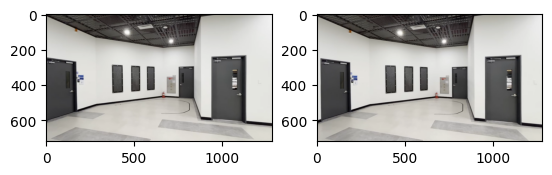

In [6]:
plt.subplot(1,2,1); plt.imshow(rgb_un1)
plt.subplot(1,2,2); plt.imshow(rgb_un2)

0 torch.Size([8, 3, 720, 1280])
1 torch.Size([8, 3, 720, 1280])
2 torch.Size([8, 3, 720, 1280])
RGB
RGB
RGB
RGB


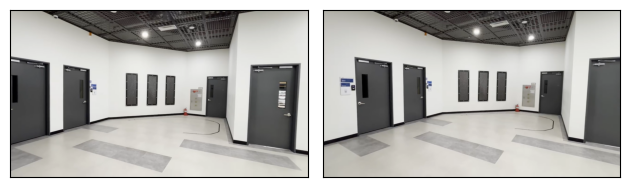

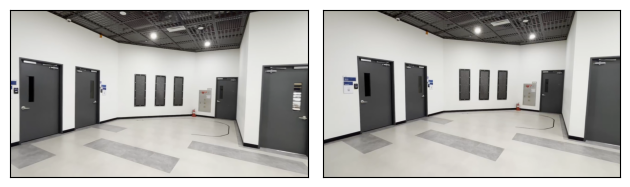

In [7]:
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

for cnt, imgs,in enumerate(dataloader):
    print(cnt, imgs.shape)
    if cnt >= 2:
        break

img1_batch = imgs[[0,-2]]
img2_batch = imgs[[2,-1]]

plot(img1_batch)
plot(img2_batch)

In [8]:
# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

img1_batch = img1_batch.to(device)
img2_batch = img2_batch.to(device)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([2, 3, 720, 1280]), dtype = torch.float32


Estimating Optical flow using RAFT

In [11]:
from torchvision.models.optical_flow import raft_small

model = raft_small(pretrained=True, progress=False).to('cpu')
model = model.eval()

list_of_flows = model(img1_batch.to('cpu'), img2_batch.to('cpu'))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Small_Weights.C_T_V2`. You can also use `weights=Raft_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


type = <class 'list'>
length = 12 = number of iterations of the model


In [12]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 720, 1280]) = (N, 2, H, W)
min = -23.15447998046875, max = 82.80718231201172


Visualizing predicted flows

RGB
flow
RGB
flow


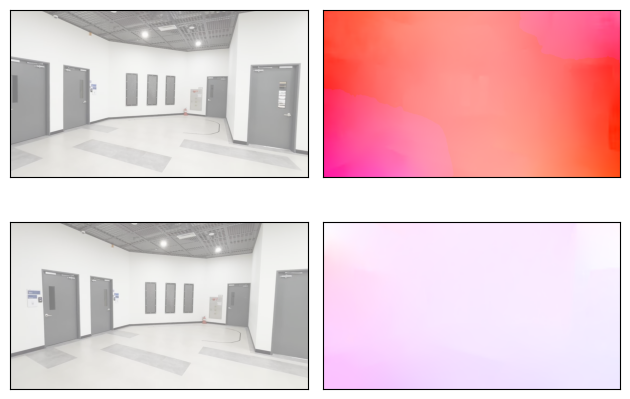

In [13]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

In [14]:
flow_imgs.dtype, img1_batch[0].dtype, flow_imgs.shape, img1_batch[0].shape

(torch.uint8,
 torch.float32,
 torch.Size([2, 3, 720, 1280]),
 torch.Size([3, 720, 1280]))

(720, 1280, 3) (2, 720, 1280)
(3600,) (3600,)
(720, 1280, 3) (2, 720, 1280)
(3600,) (3600,)


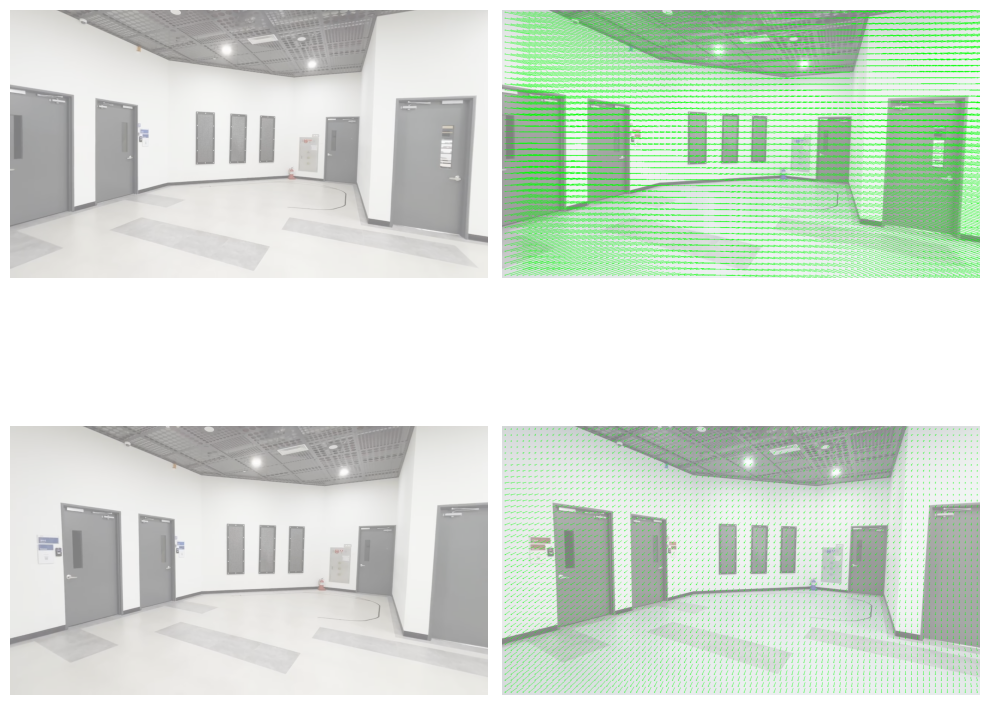

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.utils import flow_to_image

def draw_flow(img, flow, step=16):
    """Draws optical flow arrows on the image."""
    print(img.shape, flow.shape)
    # flow = flow.permute((1,2,0))
    flow = flow.transpose((1,2,0))
    h, w = img.shape[:2]
    y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)
    # print(x, y)
    fx, fy = flow[y, x].T

    # Create a mask that will be used for drawing
    print(x.shape, fx.shape)
    lines = np.vstack([x, y, x + fx, y + fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    # print(img.shape)
    vis = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # vis = np.array(img)

    # Draw the lines on the image
    cv2.polylines(vis, lines, isClosed=False, color=(0, 255, 0))

    # Draw the endpoints of the flow vectors
    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

# Assuming predicted_flows is a batch of flow vectors and img1_batch is a batch of images
flow_imgs = flow_to_image(predicted_flows)  # Convert flow vectors to images

predicted_flows_np = predicted_flows.detach().numpy() # cpu().
# Draw optical flow on images
flow_visualizations = [draw_flow(img1.cpu().numpy().transpose(1, 2, 0), flow_img) for img1, flow_img in zip(img1_batch, predicted_flows_np)]

# Setup for plotting
fig, axs = plt.subplots(len(flow_visualizations), 2, figsize=(10, len(flow_visualizations) * 5))

for i, (img, flow_viz) in enumerate(zip(img1_batch, flow_visualizations)):
    axs[i, 0].imshow(img.cpu().permute((1,2,0)), cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(flow_viz)
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


# 실습 과제 2. 본인의 pose sequence 데이터를 이용하여 순차적인 10개의 pose를 이용해 다음 3개의 pose를 예측하는 LSTM 모델을 학습시키고 결과를 논의하세요

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import os

# Pose 데이터 로드
csv_path = '/content/drive/MyDrive/숙명여대수업/전자공_딥러닝수업/df.csv'
pose_data = pd.read_csv(csv_path)

# 필요한 열만 선택 (예시: frame, paths, x, y, z, p, q, r, s)
pose_data = pose_data[['paths', 'x', 'y', 'z']]
pose_data = pose_data.sort_values('paths').reset_index(drop=True)

# NumPy 배열로 변환
pose_array = pose_data.drop('paths', axis=1).to_numpy()

# pose_array의 길이 확인
print(f'pose_array의 길이: {len(pose_array)}')

# seq_length와 pred_length 설정
seq_length = 5
pred_length = 3

# 데이터셋 클래스 정의
class PoseDataset(Dataset):
    def __init__(self, data, seq_length=5, pred_length=2):
        self.data = data
        self.seq_length = seq_length
        self.pred_length = pred_length

    def __len__(self):
        return len(self.data) - self.seq_length - self.pred_length + 1

    def __getitem__(self, idx):
        seq_start = idx
        seq_end = idx + self.seq_length
        pred_end = seq_end + self.pred_length

        x = self.data[seq_start:seq_end]
        y = self.data[seq_end:pred_end]

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# 데이터셋과 데이터로더 생성
dataset = PoseDataset(pose_array, seq_length, pred_length)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)  # batch_size를 줄여서 데이터셋의 크기에 맞춤

# 데이터셋의 길이 확인
print(f'데이터셋의 길이: {len(dataset)}')


pose_array의 길이: 15
데이터셋의 길이: 8


In [ ]:
class LSTMPosePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMPosePredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = pose_array.shape[1]
hidden_size = 64
output_size = input_size * pred_length

model = LSTMPosePredictor(input_size, hidden_size, output_size).cuda()


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in dataloader:
        x_batch = x_batch.cuda()
        y_batch = y_batch.view(y_batch.size(0), -1).cuda()

        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/30], Loss: 18.4915
Epoch [2/30], Loss: 18.2493
Epoch [3/30], Loss: 17.0293
Epoch [4/30], Loss: 16.4550
Epoch [5/30], Loss: 15.4469
Epoch [6/30], Loss: 14.2639
Epoch [7/30], Loss: 13.4793
Epoch [8/30], Loss: 12.7337
Epoch [9/30], Loss: 10.6897
Epoch [10/30], Loss: 9.9220
Epoch [11/30], Loss: 8.5553
Epoch [12/30], Loss: 7.3351
Epoch [13/30], Loss: 6.3657
Epoch [14/30], Loss: 5.1737
Epoch [15/30], Loss: 4.4112
Epoch [16/30], Loss: 3.9503
Epoch [17/30], Loss: 3.1457
Epoch [18/30], Loss: 2.8910
Epoch [19/30], Loss: 2.4782
Epoch [20/30], Loss: 2.1603
Epoch [21/30], Loss: 1.8320
Epoch [22/30], Loss: 1.6730
Epoch [23/30], Loss: 1.3910
Epoch [24/30], Loss: 1.2098
Epoch [25/30], Loss: 1.0516
Epoch [26/30], Loss: 0.9057
Epoch [27/30], Loss: 0.7860
Epoch [28/30], Loss: 0.6990
Epoch [29/30], Loss: 0.6049
Epoch [30/30], Loss: 0.5066


In [ ]:
# 모델을 평가 모드로 전환
model.eval()

# 예측을 위한 임의의 시퀀스 선택
test_seq = torch.tensor(pose_array[:seq_length], dtype=torch.float32).unsqueeze(0).cuda()

# 예측 수행
with torch.no_grad():
    predicted = model(test_seq)
    predicted = predicted.cpu().numpy().reshape(pred_length, input_size)

# 예측 결과 출력
print("예측된 포즈 시퀀스:")
print(predicted)


예측된 포즈 시퀀스:
[[ 5.554273   -3.1984704  -0.34889194]
 [ 6.0914392  -3.0263922  -0.41295958]
 [ 5.628155   -2.9433944  -0.2633856 ]]


# 실습 과제 3. Lab7에서 사용한 Depth Data를 이용하여 MiDAS 모델의 Depth Estimation을 수행하세요.


- MiDAS로 추정된 Disparity Map을 Ground Truth Depth Map과 비교하여 Metric
Depth Map으로 변환하세요. (frame 135, frame 520, frame 990)


- 추정된 Metric Depth Map과 Ground Truth Depth Map에 대한 pixel에 대한 scatter
plot을 그리세요. 2장 이상의 이미지에 대해 비교하세요. (x축 GT depth, y축 predicted depth)


Hint: 이미지 마다 다른 scale과 bias값을 이용

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.small_transform
transform

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


Loading weights:  None


Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt" to /root/.cache/torch/hub/checkpoints/midas_v21_small_256.pt
100%|██████████| 81.8M/81.8M [00:00<00:00, 134MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Compose(
    <function transforms.<locals>.<lambda> at 0x7d51c8a993f0>
    <function transforms.<locals>.<lambda> at 0x7d51c8a99480>
)

In [ ]:
class DepthDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.depth_files = [f for f in os.listdir(root_dir) if f.endswith('.depth.exr.tiff')]
        self.rgb_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.depth_files)

    def __getitem__(self, idx):
        depth_path = os.path.join(self.root_dir, self.depth_files[idx])
        rgb_path = os.path.join(self.root_dir, self.rgb_files[idx])

        depth_image = Image.open(depth_path)
        rgb_image = Image.open(rgb_path)

        if self.transform:
            depth_image = self.transform(depth_image)
            rgb_image = self.transform(rgb_image)

        return rgb_image, depth_image

path = '/content/drive/MyDrive/숙명여대수업/전자공_딥러닝수업/resized_images'
dataset = DepthDataset(path, transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)


Metric Depth Map 변환

In [ ]:
def scale_and_bias(prediction, ground_truth):
    a = np.cov(prediction.flatten(), ground_truth.flatten())[0, 1] / np.var(prediction.flatten())
    b = np.mean(ground_truth) - a * np.mean(prediction)
    metric_depth = a * prediction + b
    return metric_depth


def estimate_depth(midas, image):
    input_batch = transform(image).unsqueeze(0).to(device)  # 4D 텐서로 변환

    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.size[::-1],  # (height, width)
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    return prediction.cpu().numpy()

Scatter Plot

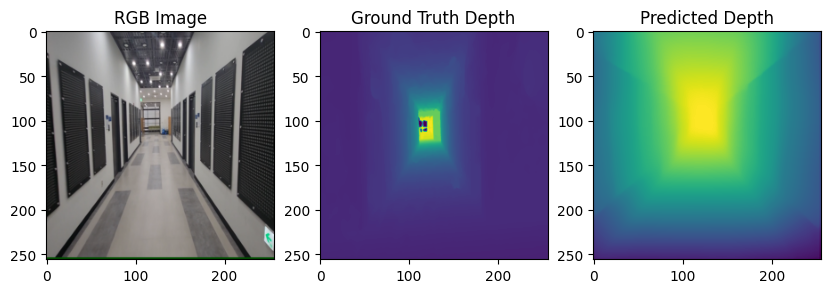

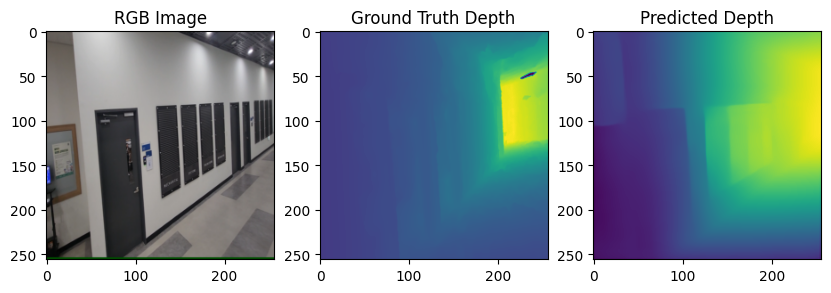

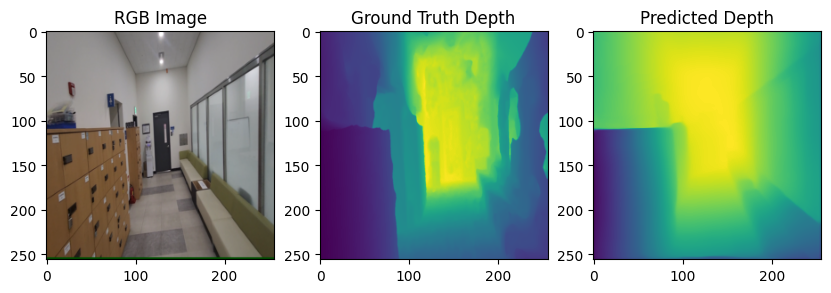

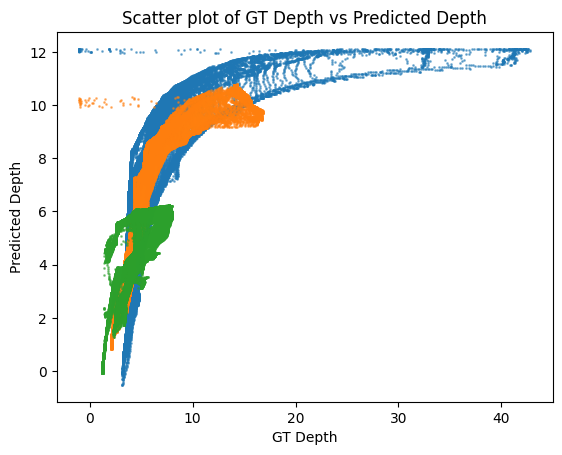

In [ ]:
frames = [134, 519, 989]

# 결과 저장을 위한 리스트
gt_depths = []
pred_depths = []

for i, (rgb_image, depth_image) in enumerate(dataloader):
    if i not in frames:
        continue

    rgb_image = rgb_image.squeeze().permute(1, 2, 0).cpu().numpy()
    depth_image = depth_image.squeeze().cpu().numpy()

    # MiDAS를 사용하여 깊이 추정
    input_batch = transform(Image.fromarray((rgb_image * 255).astype(np.uint8))).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=rgb_image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze().cpu().numpy()

    # Metric Depth Map으로 변환
    metric_depth = scale_and_bias(prediction, depth_image)

    gt_depths.append(depth_image.flatten())
    pred_depths.append(metric_depth.flatten())

    # 그래프 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(rgb_image)
    plt.title("RGB Image")
    plt.subplot(1, 3, 2)
    plt.imshow(depth_image, cmap='viridis')
    plt.title("Ground Truth Depth")
    plt.subplot(1, 3, 3)
    plt.imshow(metric_depth, cmap='viridis')
    plt.title("Predicted Depth")
    plt.show()

# 두 개 이상의 이미지에 대해 GT depth와 predicted depth의 scatter plot 그리기
for i in range(len(gt_depths)):
    plt.scatter(gt_depths[i], pred_depths[i], s=1, alpha=0.5)
plt.xlabel('GT Depth')
plt.ylabel('Predicted Depth')
plt.title('Scatter plot of GT Depth vs Predicted Depth')
plt.show()